In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Save dataset
os.system('wget -O train_data.csv "https://docs.google.com/spreadsheets/d/176-KrOP8nhLpoW91UnrOY9oq_-I0XYNKS1zmqIErFsA/gviz/tq?tqx=out:csv&sheet=train_data.csv" -q')
os.system('wget -O val_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv" -q')
os.system('wget -O test_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv" -q')

0

In [4]:
import pandas as pd
df_train = pd.read_csv('train_data.csv')
df_valid = pd.read_csv('val_data.csv')
df_test = pd.read_csv('test_data.csv')

In [5]:
df_train.head()

,review,sentiment
0,I've watched this documentary twice - and alth...,positive
1,This is probably the worst movie I've seen in ...,negative
2,Superb story of a dedicated young teacher who ...,positive
3,<br /><br />Spoilers<br /><br />I'm going to b...,negative
4,"What can be said, really... ""The Tenant"" is a ...",positive


In [6]:
# Prepare data as X, Y
Xd, Yd = df_train.review.values.tolist(), df_train.sentiment.values.tolist()
Xv, Yv = df_valid.review.values.tolist(), df_valid.sentiment.values.tolist()
Xt, Yt = df_test.review.values.tolist(), df_test.sentiment.values.tolist()

sentiment = ['negative', 'positive']
Yd = [sentiment.index(y) for y in Yd]
Yv = [sentiment.index(y) for y in Yv]
Yt = [sentiment.index(y) for y in Yt]

## Rule based classification

In [7]:
# Extract features
def extract_features(X):
    
    feats = {'good_count': 0, 'bad_count': 0, 'bias': 1}
    words = X.split(' ')
    pos_words = ['good', 'great', 'excellent', 'positive', 'love', 'like', 
                 'awesome', 'amazing', 'wonderful', 'best', 'better', 
                 'beautiful', 'nice', 'fantastic', 'superb', 
                 'incredible', 'perfect', 'well', 'fun', 'enjoy', 
                 'enjoyable', 'enjoyed', 'enjoying', 'enjoyment']
    
    neg_words = ['hate', 'bad', 'horrible', 'awful', 'terrible', 'mess', 'frustating', 'frustatingly',
                 'worst', 'dumb', 'poor']
    
    for x in words:
        if x in pos_words:
            feats['good_count'] = feats.get('good_count', 0) + feats['bias']
        if x in neg_words:
            feats['bad_count'] = feats.get('good_count', 0) + feats['bias'] 
    return feats

def predict(X, w):
    feats = extract_features(X)
    score = 0
    for f in feats:
        score += feats[f] * w[f]
    return 1 if score > 0 else 0

def get_feature_weights():
    return {'good_count': 1.0, 'bad_count': -1.0, 'bias': 0.5}

def accuracy(Y_true, Y_pred):
    correct = 0.0
    total = len(Y_true)
    assert total == len(Y_pred)

    for i in range(total):
        if Y_true[i] == Y_pred[i]:
            correct += 1
    
    if total > 0:
        return 100.0 * correct / total
    return 0.0


In [8]:
feats_wt = get_feature_weights()
predictions = []

for x in Xt:
    y = predict(x, feats_wt)
    predictions.append(y)

print(accuracy(Yt, predictions))

60.475


In [18]:
from sklearn.linear_model import LogisticRegression
def get_learnable_wt(Xd, Yd):
    feats_name = list(extract_features(Xd[0]).keys())
    all_feats = []
    for x in Xd:
        feats = []
        feat_dict = extract_features(x)
        for f in feats_name:
            feats.append(feat_dict[f])
        all_feats.append(feats)

    clf = LogisticRegression(fit_intercept=False, random_state = 42).fit(all_feats, Yd)
    coeffs = clf.coef_[0]
    coffs_dict = {feats_name[i]: coeffs[i] for i in range(len(feats_name))}
    return coffs_dict

In [19]:
feats_wt_logistic = get_learnable_wt(Xd, Yd)
predictions = []

for x in Xt:
    y = predict(x, feats_wt_logistic)
    predictions.append(y)

print("Accuracy on Logistic Regression : ",accuracy(Yt, predictions))

Accuracy on Logistic Regression :  66.7


(-2.0, 2.0)

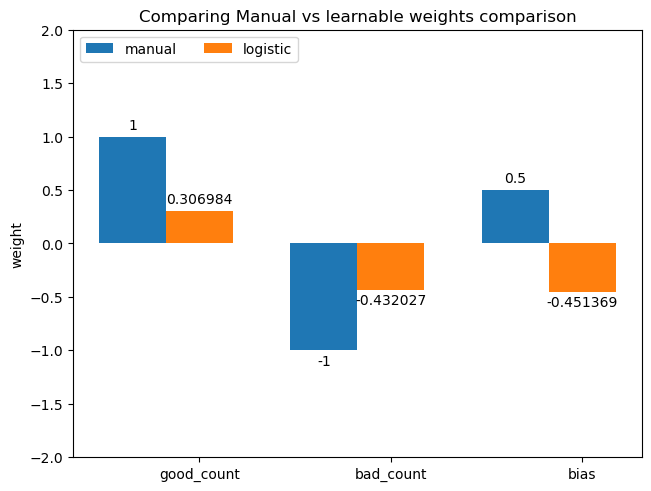

In [17]:
import matplotlib.pyplot as plt
import numpy as np

feats_names = list(feats_wt_logistic.keys())
manual_wt = [feats_wt[f] for f in feats_names]
logistic_wt = [feats_wt_logistic[f] for f in feats_names]

wt_dict = {'manual': manual_wt, 'logistic': logistic_wt}
x = np.arange(len(feats_names))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained');

for attribute, measurement in wt_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weight')
ax.set_title('Comparing Manual vs learnable weights comparison')
ax.set_xticks(x + width, feats_names)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(-2, 2)

## Using Bag of Words

In [145]:
import collections

def word_to_idx(X, k = 1000):
    
    all_text = ' '.join(X)
    words = all_text.split()
    word_counts = collections.Counter(words)
    top_k_words = [word for word,_ in word_counts.most_common(k)]
    #print(top_k_words)
    word_idx = {word: idx for idx, word in enumerate(top_k_words)}

    return word_idx

In [146]:
def extract_features_bow(X, word_idx):
    features = {word: 0 for word in word_idx}
    words = X.split()
    for word in words:
        if word in word_idx:
            features[word] += 1
    return features

In [151]:
samples = [
    "When is the money due ?",
    "When are the TAs' office hours ?",
    "How hard is the job ?",
]
word_idx = word_to_idx(samples)
features = extract_features_bow(samples[0]+samples[1]+samples[2], word_idx)
for f in features:
    print(f,"\t", features[f])

the 	 3
? 	 1
When 	 1
is 	 2
money 	 1
due 	 1
are 	 1
TAs' 	 1
office 	 1
hours 	 1
How 	 0
hard 	 1
job 	 1


In [160]:
def learnable_word_to_idx(X, Y):
    
    word_idx = word_to_idx(X)
    feats_names = list(word_idx.keys())
    
    all_feats = []
    for x in X:
        f = []
        feats_dict = extract_features_bow(x, word_idx)
        
        for name in feats_names:
            f.append(feats_dict[name])
        all_feats.append(f)
    
    clf = LogisticRegression(fit_intercept = False, random_state = 42).fit(all_feats, Y)
    coeffs = clf.coef_[0]
    coeffs_dict = {feats_names[i]: coeffs[i] for i in range(len(feats_names))}
                  
    return coeffs_dict

In [161]:
def predict_bow(X, feature_wt):
    features = extract_features_bow(X, feature_wt)
    score = 0
    for f_name, f_value in features.items():
        score = score + f_value * feature_wt[f_name]
        #print(feature_wt[f_name])#f_name, f_value, score)

    return 1 if score > 0 else 0

In [169]:
import warnings
warnings.filterwarnings('ignore')

learned_feature_wt = learnable_word_to_idx(Xd, Yd)
print("Learned feature weights :\n", list(learned_feature_wt.items())[:5])
preds = []
for x in Xt:
    y = predict_bow(x, learned_feature_wt)
    preds.append(y)

print("Accuracy on logistic regression on bow : ",accuracy(Yt, preds))

Learned feature weights :
 [('the', -0.004318820945718367), ('a', -0.021809221215482306), ('and', 0.06340784541294252), ('of', 0.024747638623110406), ('to', -0.002926818407115192)]
Accuracy on logistic regression on bow :  81.55


In [164]:
most_positive = sorted(learned_feature_wt, key=learned_feature_wt.get, reverse=True)[:5]
most_negative = sorted(learned_feature_wt, key=learned_feature_wt.get, reverse=False)[:5]

print("Most positive words : ", most_positive)
print("Most negative words : ", most_negative)

Most positive words :  ['excellent', 'amazing', 'favorite', 'perfect', 'wonderful']
Most negative words :  ['waste', 'worst', 'poorly', 'fails', 'poor']


## Word2Vec

Word2Vec model has Continuous bag of word and Skipgram architectures.

In [247]:
import os
from functools import partial
from typing import Union, Tuple

from torchtext._internal.module_utils import is_module_available
from torchtext.data.datasets_utils import (
    _wrap_split_argument,
    _create_dataset_directory,
)

URL = "https://huggingface.co/Ayushkm10/SpeechToText/resolve/main/text2.zip"


NUM_LINES = {
    "train": 36718,
    "valid": 3760,
}

DATASET_NAME = "WikiText2"

_EXTRACTED_FILES = {
    "train": os.path.join("wikitext-2", "wiki.train.tokens"),
    "test": os.path.join("wikitext-2", "wiki.test.tokens"),
    "valid": os.path.join("wikitext-2", "wiki.valid.tokens"),
}


def _filepath_fn(root, _=None):
    return os.path.join(root, os.path.basename(URL))


def _extracted_filepath_fn(root, split, _=None):
    return os.path.join(root, _EXTRACTED_FILES[split])


def _filter_fn(split, x):
    return _EXTRACTED_FILES[split] in x[0]


def WikiText21(root: str, split: Union[Tuple[str], str]):
    """WikiText2 Dataset

    .. warning::

        using datapipes is still currently subject to a few caveats. if you wish
        to use this dataset with shuffling, multi-processing, or distributed
        learning, please see :ref:`this note <datapipes_warnings>` for further
        instructions.

    For additional details refer to https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/

    Number of lines per split:
        - train: 36718
        - valid: 3760
        - test: 4358

    Args:
        root: Directory where the datasets are saved. Default: os.path.expanduser('~/.torchtext/cache')
        split: split or splits to be returned. Can be a string or tuple of strings. Default: (`train`, `valid`, `test`)

    :returns: DataPipe that yields text from Wikipedia articles
    :rtype: str
    """
    if not is_module_available("torchdata"):
        raise ModuleNotFoundError(
            "Package `torchdata` not found. Please install following instructions at https://github.com/pytorch/data"
        )
    from torchdata.datapipes.iter import FileOpener, GDriveReader, HttpReader, IterableWrapper  # noqa

    url_dp = IterableWrapper([URL])
    # cache data on-disk
    cache_compressed_dp = url_dp.on_disk_cache(
        filepath_fn=partial(_filepath_fn, root),
    )
    cache_compressed_dp = HttpReader(cache_compressed_dp).end_caching(mode="wb", same_filepath_fn=True)
    cache_decompressed_dp = cache_compressed_dp.on_disk_cache(filepath_fn=partial(_extracted_filepath_fn, root, split))
    # Extract zip and filter the appropriate split file
    cache_decompressed_dp = (
        FileOpener(cache_decompressed_dp, mode="b").load_from_zip().filter(partial(_filter_fn, split))
    )
    cache_decompressed_dp = cache_decompressed_dp.end_caching(mode="wb", same_filepath_fn=True)
    data_dp = FileOpener(cache_decompressed_dp, encoding="utf-8")
    return data_dp.readlines(strip_newline=False, return_path=False).shuffle().set_shuffle(False).sharding_filter()

In [277]:
from torchtext.data import get_tokenizer, to_map_style_dataset
from torchtext.datasets import WikiText2
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset

MIN_WORD_FREQ = 5
CONTEXT_LEN = 2
MAX_SEQ_LEN = 150

class TextDataset(Dataset):

    def __init__(self, file_path):
        with open(file_path, 'r') as f:
            self.texts = f.readlines()

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx].strip()
    
def get_data_iterator(ds_type, data_dir):
    file_path = f"{data_dir}/{ds_type}.txt"
    dataset = TextDataset(file_path)
    return dataset

def build_vocab(data_iter, tokenizer):
    vocab = build_vocab_from_iterator(map(tokenizer, data_iter), specials=["<unk>"],
                                      min_freq=MIN_WORD_FREQ)
    
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [278]:
import torch
import torch.nn as nn

def collate(batch, text_pipeline):
    batch_in, batch_out = [], []

    for text in batch:
        tokens = text_pipeline(text)
        if len(tokens) < CONTEXT_LEN * 2 + 1:# Context length on both sides
            continue

        if MAX_SEQ_LEN > 0:
            tokens = tokens[:MAX_SEQ_LEN]

        for i in range(len(tokens) - CONTEXT_LEN * 2):
            context = tokens[i:i + CONTEXT_LEN * 2 + 1]
            input = context.pop(CONTEXT_LEN)
            outputs = context

            for output in outputs:
                batch_in.append(input)
                batch_out.append(output)

    batch_in = torch.tensor(batch_in, dtype=torch.long)
    batch_out = torch.tensor(batch_out, dtype=torch.long)

    return batch_in, batch_out

In [279]:
from functools import partial

def get_dataloader_vocab(ds_type, data_dir, batch_size, shuffle=True, vocab=None):
    
    data_iter = get_data_iterator(ds_type, data_dir)
    tokenizer = get_tokenizer("basic_english")

    if vocab is None:
        vocab = build_vocab(data_iter, tokenizer)
    text_pipeline = lambda x: vocab(tokenizer(x))
    
    dataloader = DataLoader(data_iter, batch_size=batch_size, shuffle=shuffle,
                            collate_fn=partial(collate, text_pipeline=text_pipeline))
    
    return dataloader, vocab

In [280]:

class Skipgram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        x = self.linear(x)
        return x
    
    def get_word_embedding(self):
        embed_data = self.embed.weight.data
        normalized_embed_data = embed_data / np.linalg.norm(embed_data, axis=1)[:, None]

        return normalized_embed_data

In [284]:
import json
class Trainer:
    def __init__(self, model, epochs, train_dl, valid_dl,
                 criterion, optimizer, device, model_dir, model_name):
        
        self.model = model
        self.epochs = epochs
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name

        self.loss = { 'train': [], 'valid': [] }
        self.model.to(device)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for x, y in self.train_dl:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(x)
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        
        return total_loss / len(self.train_dl)
    
    def valid_epoch(self):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x, y in self.valid_dl:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.criterion(output, y)
                total_loss += loss.item()
            
        return total_loss / len(self.valid_dl)
    
    def save_model(self):
        torch.save(self.model.state_dict(), f"{self.model_dir}/{self.model_name}.pt")

    def save_loss(self):
        loss_path = os.path.join(self.model_dir, f"{self.model_name}_loss.json")
        with open(loss_path, 'wb') as f:
            json.dump(self.loss, f)

    def train(self):
        for epoch in range(self.epochs):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            self.loss['train'].append(train_loss)
            self.loss['valid'].append(valid_loss)
            print(f"Epoch {epoch+1}/{self.epochs}: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
        
        self.save_model()
        self.save_loss()

In [285]:
# Setting Parameters
model_name = "skipgram"
data_dir = "data"
train_batch_size = 32
valid_batch_size = 32
shuffle = True
optimizer = torch.optim
criterion = nn.CrossEntropyLoss()
epochs = 4

model_dir = "."
EMBED_SIZE = 100

In [289]:
# get_dataloader_vocab(ds_type, data_dir, batch_size, shuffle=True, vocab=None):
train_dl, vocab = get_dataloader_vocab("train", data_dir, train_batch_size, shuffle)
valid_dl, _ = get_dataloader_vocab("valid", data_dir, valid_batch_size, vocab=vocab)

vocab_size = len(vocab.get_stoi())
print("Vocab Size : ", vocab_size)

model = Skipgram(vocab_size, EMBED_SIZE)
optimizer = torch.optim.Adam(model.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer(model, epochs, train_dl, valid_dl, criterion, optimizer, device, model_dir, model_name)
trainer.train()
print("Training Completed")

vocab_path = os.path.join(model_dir, f"{model_name}_vocab.pt")
torch.save(vocab, vocab_path)
print("Vocab file saved", vocab_path)

Vocab Size :  19538
Epoch 1/4: Train Loss: 7.5824, Valid Loss: 6.5245
Epoch 2/4: Train Loss: 6.6352, Valid Loss: 6.3374
Epoch 3/4: Train Loss: 6.4864, Valid Loss: 6.2854
Epoch 4/4: Train Loss: 6.4158, Valid Loss: 6.2577


TypeError: a bytes-like object is required, not 'str'

### Analysis of performance of Skipgram model

In [290]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = torch.load(f"{model_dir}/{model_name}.pt", map_location=device)
# vocab = torch.load(vocab_path)

word_embedding = model.get_word_embedding()
np.save(f"{model_dir}/{model_name}_word_embedding.npy", word_embedding)

In [315]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(words):
    word_vectors = [word_embedding[vocab[word]] for word in words]
    word_vectors = [w.numpy() for w in word_vectors]
    
    norm = np.linalg.norm(word_vectors, axis=1, keepdims=True)
    normalized_word_vectors = word_vectors / norm

    similarity_matrix = np.dot(normalized_word_vectors, normalized_word_vectors.T)

    similarity = cosine_similarity(normalized_word_vectors)
    return word_vectors, similarity


In [316]:
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

word_vectors, similarity = get_similarity(words)
df = pd.DataFrame(similarity, index = words, columns = words)
df

,king,queen,river,water,ocean,tree,plant,happy,glad,mother,daughter
king,1.000000,0.210590,-0.036448,0.055717,-0.151465,0.127803,-0.122636,0.021989,-0.057632,0.113291,0.141425
queen,0.210590,1.000000,-0.017246,-0.031548,0.035303,-0.075660,0.080333,-0.084932,0.207922,0.036996,0.086051
river,-0.036448,-0.017246,1.000000,0.165698,-0.032748,0.309853,0.130715,-0.153476,-0.189851,-0.026085,-0.076089
water,0.055717,-0.031548,0.165698,1.000000,-0.008978,0.035917,-0.046715,-0.000505,-0.085882,0.089777,0.062529
ocean,-0.151465,0.035303,-0.032748,-0.008978,1.000000,-0.058752,0.105082,-0.044772,0.092742,0.018859,-0.015513
tree,0.127803,-0.075660,0.309853,0.035917,-0.058752,1.000000,-0.080545,-0.117196,-0.130718,-0.045972,0.136099
plant,-0.122636,0.080333,0.130715,-0.046715,0.105082,-0.080545,1.000000,-0.042293,0.077504,-0.058070,-0.194986
happy,0.021989,-0.084932,-0.153476,-0.000505,-0.044772,-0.117196,-0.042293,1.000000,0.081790,-0.040551,0.065216
glad,-0.057632,0.207922,-0.189851,-0.085882,0.092742,-0.130718,0.077504,0.081790,1.000000,0.150656,0.158542
mother,0.113291,0.036996,-0.026085,0.089777,0.018859,-0.045972,-0.058070,-0.040551,0.150656,1.000000,0.114590


<Axes: >

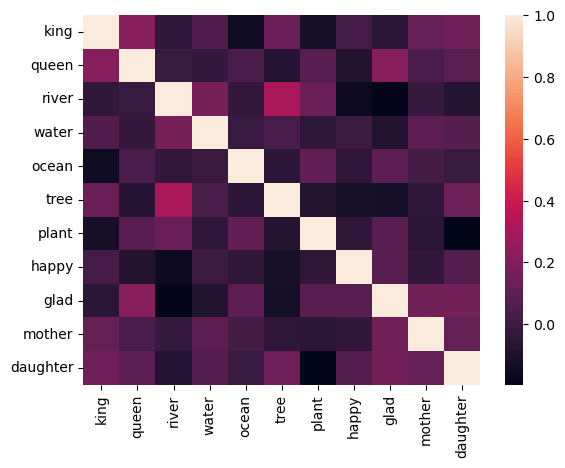

In [318]:
import seaborn as sns
sns.heatmap(df)

In [319]:
# Dimensionality Reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_word_vectors = pca.fit_transform(word_vectors)

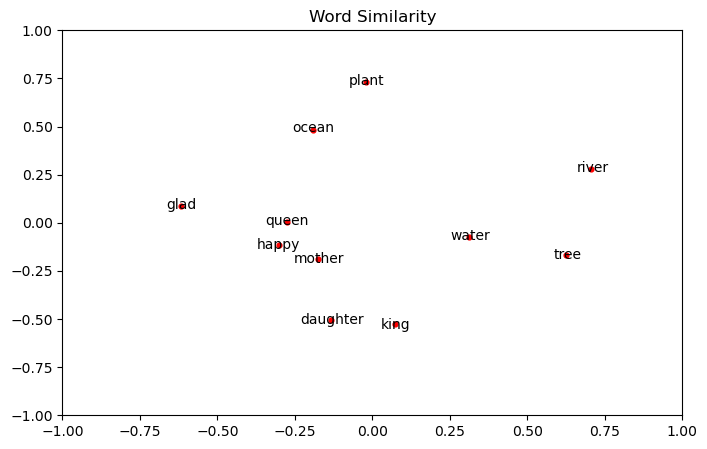

In [320]:
plt.figure(figsize=(8, 5))
plt.scatter(reduced_word_vectors[:, 0], reduced_word_vectors[:, 1], s = 12, color = "red")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title("Word Similarity")
x, y = reduced_word_vectors[:, 0], reduced_word_vectors[:, 1]
offset = 0.5
for i in range(len(x)):
    label = words[i]
    plt.annotate(label, (x[i], y[i]), xytext=(x[i] + offset, y[i] + offset),
                 textcoords = 'offset points', ha = 'center', va = 'center')

In [334]:
def get_top_similarity(word:str, top_n:int = 10):
    word_id = vocab[word]
    if word_id is None:
        print(f"{word} not found in vocab")
        return
    
    word_vector = word_embedding[word_id]
    word_vector = np.reshape(word_vector, (len(word_vector), 1))

    distance = np.matmul(word_embedding, word_vector).flatten()
    top_n_idx = np.argsort(-distance)[1:top_n+1]

    top_n_dict = {}
    for i in top_n_idx:
        similar_word = vocab.lookup_token(i)
        top_n_dict[similar_word] = distance[i]

    return top_n_dict

In [337]:
s = "king"
print(f"Top 5 Similar words for {s}")
print("Word            | Similarity")
print("----------------------------")
for word, similar_words in get_top_similarity(s).items():
    print(f"{word:10} \t| {similar_words.item():.3f}")

Top 5 Similar words for king
Word            | Similarity
----------------------------
recent     	| 0.369
container  	| 0.368
1821       	| 0.363
recipient  	| 0.362
fallon     	| 0.353
stops      	| 0.348
realise    	| 0.339
balestre   	| 0.337
1617       	| 0.337
morphology 	| 0.333


### Analogy tests

Solving `A:B::C:_` <=> if A is similar to B, then C is similar to _.

In [338]:
def get_analogy( w1, w2, w3):

    emb1 = word_embedding[vocab[w1]]
    emb2 = word_embedding[vocab[w2]]
    emb3 = word_embedding[vocab[w3]]

    emb4 = emb1 - emb2 + emb3

    emb4 = np.reshape(emb4, (len(emb4), 1))
    dot_product = np.matmul(word_embedding, emb4).flatten()
    top_5 = np.argsort(-dot_product)[1:6]

    return top_5, dot_product

In [345]:
top_5, dot_product = get_analogy("king", "man","woman")
print("Top 5 words for analogy - king : man :: woman : ?")
print("Word             Similarity")
for i in top_5:
    print(f"{vocab.lookup_token(i):10} {dot_product[i]}")

Top 5 words for analogy - king : man :: woman : ?
Word             Similarity
woman      0.8448806405067444
realise    0.6310297250747681
buchan     0.6225563287734985
gull       0.6106157898902893
booming    0.6097330451011658


### Measure Precision

In [346]:
# Downloading analogy dataset
os.system('wget -O data/analogy_data.txt "https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2"')

--2024-08-15 00:14:36--  https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2
Resolving drive.google.com (drive.google.com)... 142.250.183.110, 2404:6800:4009:827::200e
Connecting to drive.google.com (drive.google.com)|142.250.183.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jHx25dECegjtRKBB587nEfHiJesrH0g2&export=download [following]
--2024-08-15 00:14:36--  https://drive.usercontent.google.com/download?id=1jHx25dECegjtRKBB587nEfHiJesrH0g2&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.183.65, 2404:6800:4009:81e::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.183.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286075 (279K) [application/octet-stream]
Saving to: ‘data/analogy_data.txt’

     0K .......... .......... .......... .......... .......... 17

0

In [387]:
import random
random.seed(42)

def get_analogy_samples(file_path, num_samples = 5000):
    with open(file_path, 'r') as f:
        analogies = []
        for line in f:
            #print(line)
            parts = line.strip().split()

            if len(parts) == 4:
                analogies.append(parts)

        analogies = random.sample(analogies, min(num_samples, len(analogies)))
        print(f"Total Analogies : {len(analogies)}")
        return analogies

In [388]:
file_path = "data/analogy_data.txt"
analogy_data = get_analogy_samples(file_path)

Total Analogies : 5000


In [391]:
def get_word_idx(word):
    return vocab[word] if word in vocab else None

def get_precision(analogy_data):
    total = 0
    correct = 0

    for a,b,c,d in  analogy_data:
        a,b,c,d = a.lower(), b.lower(), c.lower(), d.lower()

        if not all([get_word_idx(w) for w in [a,b,c,d]]):
            continue

        top_5, _ = get_analogy(a, b, c)
        predicted_words = []

        for i in top_5:
            word = vocab.lookup_token(i)
            predicted_words.append(word)

        if d in predicted_words:
            correct += 1
        total += 1
    print(f"{correct} correct out of {total} total")
    precision = correct / total if total > 0 else 0
    return precision

In [392]:
precision = get_precision(analogy_data)
print("Analogy Precision : ", precision)
# Required training more epochs to get better results

0 correct out of 2787 total
Analogy Precision :  0.0


### Comparision with Google word2vec

In [353]:
# Downloading analogy dataset
os.system('wget -O data/GoogleNews-vectors-negative300.bin "https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2"')

--2024-08-15 00:16:09--  https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2
Resolving drive.google.com (drive.google.com)... 142.250.183.14, 2404:6800:4009:821::200e
Connecting to drive.google.com (drive.google.com)|142.250.183.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jHx25dECegjtRKBB587nEfHiJesrH0g2&export=download [following]
--2024-08-15 00:16:09--  https://drive.usercontent.google.com/download?id=1jHx25dECegjtRKBB587nEfHiJesrH0g2&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.183.65, 2404:6800:4009:81e::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.183.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286075 (279K) [application/octet-stream]
Saving to: ‘data/GoogleNews-vectors-negative300.bin’

     0K .......... .......... .......... ........

0

In [356]:
import bs4
import requests
import tqdm.auto as tqdm

def prepare_data(url, file_path):
    response = requests.get(url, stream=True)
    response.raise_for_status() # check for errors

    if 'html' in response.headers['Content-Type']:
        response = requests.get(url)
        soup = bs4.BeautifulSoup(response.text, features='lxml') # parse the HTML
        if form := soup.find('form', id = 'download-form'):
            id = form.select_one('input[name="id"]')['value']
            uuid = form.select_one('input[name="uuid"]')['value']
            data = {
                'id': id,
                'uuid': uuid,
                'export': 'download',
                'confirm': 't'
            }
            response = requests.get(soup.find('form')['action'], params = data, stream = True)
            response.raise_for_status()

    with open(file_path, 'wb+') as f:
        with tqdm.tqdm(
            total = int(response.headers["Content-Length"]),
            unit = 'B',
            unit_scale = True,
            unit_divisor = 1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size = 1024):
                f.write(chunk)
                pbar.update(len(chunk))
    print("Downloaded to", file_path)            

In [358]:
drive_link = "https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg"
target_path = "data/GoogleNews-vectors-negative300.bin"

prepare_data(drive_link, target_path)

  0%|          | 0.00/3.39G [00:00<?, ?B/s]

Downloaded to data/GoogleNews-vectors-negative300.bin


In [359]:
from gensim.models import KeyedVectors

google_model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True, limit=50000)

In [367]:
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

def get_similarity_google(words):
    word_vectors = [google_model[word] for word in words]
    word_vectors = [w for w in word_vectors]
    
    norm = np.linalg.norm(word_vectors, axis=1, keepdims=True)
    normalized_word_vectors = word_vectors / norm

    similarity_matrix = np.dot(normalized_word_vectors, normalized_word_vectors.T)

    similarity = cosine_similarity(normalized_word_vectors)
    return word_vectors, similarity

In [368]:
gword_vectors, gsimilarity = get_similarity_google(words)
print(len(gword_vectors))
pd.DataFrame(gsimilarity, index = words, columns = words)

11


,king,queen,river,water,ocean,tree,plant,happy,glad,mother,daughter
king,1.000000,0.651096,0.086155,0.035606,0.065263,0.109141,0.057788,0.113239,0.063524,0.160052,0.148813
queen,0.651096,1.000000,0.103566,0.018264,0.099157,0.112222,0.088803,0.121214,0.082538,0.288445,0.305139
river,0.086155,0.103566,1.000000,0.576898,0.477181,0.230746,0.201330,0.073289,0.071341,0.131063,0.116944
water,0.035606,0.018264,0.576898,1.000000,0.471691,0.196022,0.271738,0.067675,0.085623,0.110723,0.079457
ocean,0.065263,0.099157,0.477181,0.471691,1.000000,0.141859,0.067005,-0.000511,0.014122,0.105623,0.081207
tree,0.109141,0.112222,0.230746,0.196022,0.141859,1.000000,0.265187,0.076933,0.105760,0.188985,0.173519
plant,0.057788,0.088803,0.201330,0.271738,0.067005,0.265187,1.000000,-0.010519,-0.000679,0.148805,0.092466
happy,0.113239,0.121214,0.073289,0.067675,-0.000511,0.076933,-0.010519,1.000000,0.740889,0.119672,0.152536
glad,0.063524,0.082538,0.071341,0.085623,0.014122,0.105760,-0.000679,0.740889,1.000000,0.125566,0.181102
mother,0.160052,0.288445,0.131063,0.110723,0.105623,0.188985,0.148805,0.119672,0.125566,1.000000,0.870623


<Axes: >

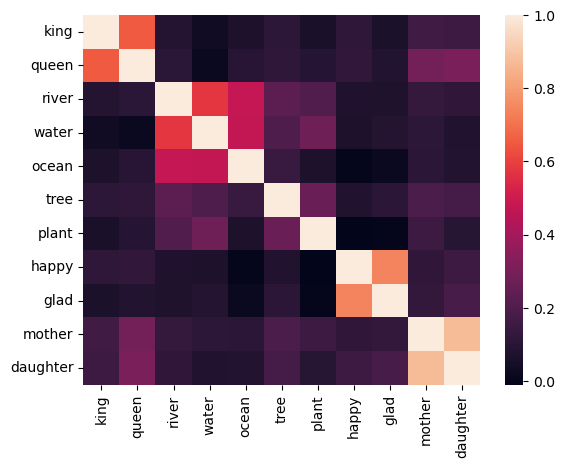

In [369]:
sns.heatmap(pd.DataFrame(gsimilarity, index = words, columns = words))

In [370]:
pca = PCA(n_components=2)
greduced_word_vectors = pca.fit_transform(gword_vectors)

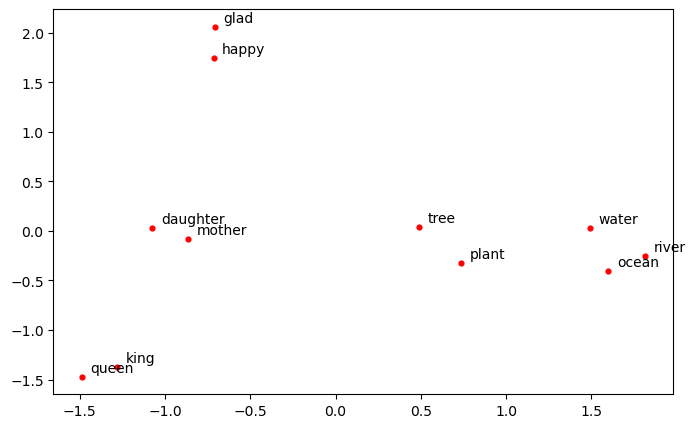

In [371]:
plt.figure(figsize=(8, 5))
x, y = greduced_word_vectors[:, 0], greduced_word_vectors[:, 1]
plt.scatter(x, y, s = 12, color = "red")
offset = 0.05
for i in range(len(x)):
    plt.annotate(words[i], xy = (x[i], y[i]), xytext = (x[i] + offset, y[i] + offset),)

In [373]:
google_model.most_similar("India")

[('Pakistan', 0.6706861257553101),
 ('Delhi', 0.6632035374641418),
 ('Bangalore', 0.6583030819892883),
 ('subcontinent', 0.6579218506813049),
 ('Bangladesh', 0.6527796983718872),
 ('sub_continent', 0.650303840637207),
 ('Mumbai', 0.6495688557624817),
 ('Sri_Lanka', 0.6445952653884888),
 ('Chennai', 0.64213627576828),
 ('Hyderabad', 0.6390925645828247)]

In [374]:
def analogy_google(a, b, c):
    return google_model.most_similar(positive=[b, c], negative=[a], topn=5)

for i in analogy_google('man', 'king','woman'):
    print(f"{i[0]:10} {i[1]}")

queen      0.7118193507194519
monarch    0.6189674735069275
princess   0.5902431011199951
prince     0.5377321243286133
kings      0.5236844420433044


In [407]:
def precision_google(analogy_data):
    total = 0
    correct = 0
    for a,b,c,d in  analogy_data:
        a,b,c,d = a.lower(), b.lower(), c.lower(), d.lower()

        # Check if google_model contains the word
        if not all([w in google_model for w in [a,b,c,d]]):
            continue
        predicted_words = [i[0] for i in analogy_google(a, b, c)]
        if d in predicted_words:
            correct += 1
        total += 1
    print(f"{correct} correct out of {total} total")
    precision = correct / total if total > 0 else 0
    return precision

In [408]:
precision_google = precision_google(analogy_data)
print("Analogy Precision :-")
print("Model Precision        : ", precision)
print("Google Model Precision : ", precision_google)

4036 correct out of 4573 total
Analogy Precision :-
Model Precision        :  0.0
Google Model Precision :  0.8825716160069976
